## Feature Extraction

In [174]:
import librosa
from librosa.feature import mfcc as mfcc
import librosa.display
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
import scipy
import os
from sklearn.preprocessing import normalize
from sklearn.preprocessing import MinMaxScaler

In [175]:
def lin(sr, n_fft, n_filter=128, fmin=0.0, fmax=None, dtype=np.float32):

    if fmax is None:
        fmax = float(sr) / 2
    # Initialize the weights
    n_filter = int(n_filter)
    weights = np.zeros((n_filter, int(1 + n_fft // 2)), dtype=dtype)

    # Center freqs of each FFT bin
    fftfreqs = librosa.fft_frequencies(sr=sr, n_fft=n_fft)

    # 'Center freqs' of liner bands - uniformly spaced between limits
    linear_f = np.linspace(fmin, fmax, n_filter + 2)

    fdiff = np.diff(linear_f)
    ramps = np.subtract.outer(linear_f, fftfreqs)

    for i in range(n_filter):
        # lower and upper slopes for all bins
        lower = -ramps[i] / fdiff[i]
        upper = ramps[i + 2] / fdiff[i + 1]

        # .. then intersect them with each other and zero
        weights[i] = np.maximum(0, np.minimum(lower, upper))

    return weights


def linear_spec(y=None,
                sr=22050,
                n_fft=2048,
                hop_length=512,
                win_length=None,
                window='hann',
                center=True,
                pad_mode='reflect',
                power=2.0,
                **kwargs):
    S = np.abs(
        librosa.core.stft(y=y,
                          n_fft=n_fft,
                          hop_length=hop_length,
                          win_length=win_length,
                          window=window,
                          center=center,
                          pad_mode=pad_mode))**power
    filter = lin(sr=sr, n_fft=n_fft, **kwargs)
    return np.dot(filter, S)


def lfcc(y=None,
         sr=22050,
         S=None,
         n_lfcc=20,
         dct_type=2,
         norm='ortho',
         **kwargs):
    if S is None:
        S = librosa.power_to_db(linear_spec(y=y, sr=sr, **kwargs))
    M = scipy.fftpack.dct(S, axis=0, type=dct_type, norm=norm)[:n_lfcc]
    return M

In [176]:
# !fusermount -u drive
# !google-drive-ocamlfuse drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [177]:
# from pydub import AudioSegment, effects  

# rawsound = AudioSegment.from_file("Intoxicated", "wav")  
# normalizedsound = effects.normalize(rawsound)  
# normalizedsound.export("./output.wav", format="wav")

In [178]:
# # assign directory
# directory = '/content/gdrive/MyDrive/Intoxicated'
# lfccsi = []
# # iterate over files in
# # that directory
# for filename in os.listdir(directory):
#   f = os.path.join(directory, filename)
#   # checking if it is a file
#   if os.path.isfile(f):
#     y, sr = librosa.load(f)
#     # lf = lfcc(y, sr, n_lfcc=16)
#     lf = librosa.filters.mel(sr, n_fft= 2048, n_mels = 16)
#     lff = np.mean(lf, axis=1)
#     lff = np.append(lff, 1)
#     lfccsi.append(lff)


In [179]:
# # assign directory
# directory = '/content/gdrive/MyDrive/alex-intox'
# lfccsi = []
# # iterate over files in
# # that directory
# for filename in os.listdir(directory):
#   f = os.path.join(directory, filename)
#   # checking if it is a file
#   if os.path.isfile(f):
#     y, sr = librosa.load(f)
#     lf = lfcc(y, sr, n_lfcc=16)
#     delta_lfc = librosa.feature.delta(lf)
#     final = np.concatenate((lf, delta_lfc))
#     final = normalize(final, axis=1)
#     final = np.mean(final, axis=1)
#     rmse = librosa.feature.rms(y=y)[0]
#     orms = np.mean(rmse)
#     fin = np.append(final, orms)
#     fin = np.append(fin, 1)
#     lfccsi.append(fin)


In [180]:
# zero_crossing
x1, sr1 = librosa.load('Alex_24_Intoxicated_2.wav')
x2, sr2 = librosa.load('Alex_24_sober_2.wav')
zero_crossings1 = librosa.zero_crossings(x1, pad=False)
zero_crossings2 = librosa.zero_crossings(x2, pad=False)
print(sum(zero_crossings1))
print(sum(zero_crossings2))

2610
1720


In [181]:
# assign directory
directory = '/content/gdrive/MyDrive/Intoxicated'
lfccsi = []
# iterate over files in
# that directory
for filename in os.listdir(directory):
  f = os.path.join(directory, filename)
  # checking if it is a file
  if os.path.isfile(f):
    y, sr = librosa.load(f)
    zero_crossings = librosa.zero_crossings(y, pad=False)
    zc = sum(zero_crossings)
    mf = mfcc(y, sr, n_mfcc=16)
    #mf = librosa.filters.mel(sr, n_fft=2048, n_mels = 16)
    delta_mfc = librosa.feature.delta(mf)
    final = np.concatenate((mf, delta_mfc))
    final = normalize(final, axis=1)
    final = np.mean(final, axis=1)
    rmse = librosa.feature.rms(y=y)[0]
    orms = np.mean(rmse)
    fin = np.append(final, orms)
    fin = np.append(fin, zc)
    fin = np.append(fin, 1)
    lfccsi.append(fin)

In [ ]:
# # assign directory
# directory = '/content/gdrive/MyDrive/Intoxicated'
# lfccsi = []
# # iterate over files in
# # that directory
# for filename in os.listdir(directory):
#   f = os.path.join(directory, filename)
#   # checking if it is a file
#   if os.path.isfile(f):
#     Y, sample_rate = librosa.load(f)
#     mfccs=np.mean(librosa.feature.mfcc(y=Y, sr=sample_rate, n_mfcc=16).T, axis=0)
#     mx = mfccs.max()
#     mn = mfccs.min()
#     mfc = (mfccs - mn)/(mx-mn)

#     #mf = librosa.filters.mel(sr, n_fft= 2048, n_mels = 16)
    
#     delta_mfccs = librosa.feature.delta(mfccs)
#     mx = mfccs.max()
#     mn = mfccs.min()
#     delta_mfc = (delta_mfccs - mn)/(mx-mn)
    
#     final = np.concatenate((mfc, delta_mfc))
    
#     #final2 = normalize(final1, axis=1)
#     rmse = librosa.feature.rms(y=Y)[0]
#     orms = np.mean(rmse)
#     fin = np.append(final, orms)
#     fin = np.append(fin, 1)
#     lfccsi.append(fin)

In [ ]:
# _X, sample_rate = librosa.load("Alex_24_Intoxicated_40.wav")
# mfccs=np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=16).T, axis=0)
# mx = mfccs.max()
# mn = mfccs.min()
# mfc = (mfccs - mn)/(mx-mn)
# print(mfccs.shape)
# print(mfc.shape)
# print(mfc)
# delta_mfc = librosa.feature.delta(mfccs)
# print(delta_mfc)
# print(delta_mfc.shape)

In [ ]:
# delta_mfccs = librosa.feature.delta(mfccs)
# mx = mfccs.max()
# mn = mfccs.min()
# delta_mfc = (delta_mfccs - mn)/(mx-mn)
# print(delta_mfccs.shape)
# print(delta_mfc.shape)


In [ ]:
# final = np.concatenate((mfc, delta_mfc))
# print(final.shape)

In [ ]:
# print(mf.shape)
# print(delta_mfc.shape)
# print(final1.shape)
# print(final2.shape)
# print(final3.shape)

In [ ]:
# # assign directory
# directory = '/content/gdrive/MyDrive/Sober'
# lfccss = []
# # iterate over files in
# # that directory
# for filename in os.listdir(directory):
#   f = os.path.join(directory, filename)
#   # checking if it is a file
#   if os.path.isfile(f):
#     y, sr = librosa.load(f)
#     #lf = lfcc(y, sr, n_lfcc=16)
#     lf = librosa.filters.mel(sr, n_fft= 2048, n_mels = 16)
#     lff = np.mean(lf, axis=1)
#     lff = np.append(lff, 0)
#     lfccss.append(lff)

In [ ]:
# # assign directory
# directory = '/content/gdrive/MyDrive/alex-sober'
# lfccss = []
# # iterate over files in
# # that directory
# for filename in os.listdir(directory):
#   f = os.path.join(directory, filename)
#   # checking if it is a file
#   if os.path.isfile(f):
#     y, sr = librosa.load(f)
#     lf = lfcc(y, sr, n_lfcc=16)
#     delta_lfc = librosa.feature.delta(lf)
#     final = np.concatenate((lf, delta_lfc))
#     final = normalize(final, axis=1)
#     final = np.mean(final, axis=1)
#     rmse = librosa.feature.rms(y=y)[0]
#     orms = np.mean(rmse)
#     fin = np.append(final, orms)
#     fin = np.append(fin, 0)
#     lfccss.append(fin)


In [ ]:
# assign directory
directory = '/content/gdrive/MyDrive/Sober'
lfccss = []
# iterate over files in
# that directory
for filename in os.listdir(directory):
  f = os.path.join(directory, filename)
  # checking if it is a file
  if os.path.isfile(f):
    y, sr = librosa.load(f)
    zero_crossings = librosa.zero_crossings(y, pad=False)
    zc = sum(zero_crossings)
    mf = mfcc(y, sr, n_mfcc=16)
    #mf = librosa.filters.mel(sr, n_fft=2048, n_mels = 16)
    delta_mfc = librosa.feature.delta(mf)
    final = np.concatenate((mf, delta_mfc))
    final = normalize(final, axis=1)
    final = np.mean(final, axis=1)
    rmse = librosa.feature.rms(y=y)[0]
    orms = np.mean(rmse)
    fin = np.append(final, orms)
    fin = np.append(fin, zc)
    fin = np.append(fin, 0)
    lfccss.append(fin)

/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


In [ ]:
# # assign directory
# directory = '/content/gdrive/MyDrive/Sober'
# lfccss = []
# # iterate over files in
# # that directory
# for filename in os.listdir(directory):
#   f = os.path.join(directory, filename)
#   # checking if it is a file
#   if os.path.isfile(f):    
#     Y, sample_rate = librosa.load(f)
#     mfccs=np.mean(librosa.feature.mfcc(y=Y, sr=sample_rate, n_mfcc=16).T, axis=0)
#     mx = mfccs.max()
#     mn = mfccs.min()
#     mfc = (mfccs - mn)/(mx-mn)

#     #mf = librosa.filters.mel(sr, n_fft= 2048, n_mels = 16)
    
#     delta_mfccs = librosa.feature.delta(mfccs)
#     mx = mfccs.max()
#     mn = mfccs.min()
#     delta_mfc = (delta_mfccs - mn)/(mx-mn)
    
#     final = np.concatenate((mfc, delta_mfc))
    
#     #final2 = normalize(final1, axis=1)
#     rmse = librosa.feature.rms(y=Y)[0]
#     orms = np.mean(rmse)
#     fin = np.append(final, orms)
#     fin = np.append(fin, 1)
#     lfccss.append(fin)

In [ ]:
lfccsi = np.array(lfccsi)
lfccss = np.array(lfccss)
print(lfccsi.shape)
print(lfccss.shape)

In [ ]:
main = np.concatenate((lfccsi, lfccss), axis=0)

In [ ]:
main.shape

In [ ]:
# DATABASE_PATH = '/content/gdrive/MyDrive/intox-temp'
# lfccsi = []
# import glob



# for file in os.listdir(DATABASE_PATH):
#   y, sr = librosa.load(file)
#   lf = lfcc(y, sr, n_lfcc=16)
#   lff = np.mean(lf, axis=1)
#   print(len(lff))
#   lfccsi.append(lff, axis = 0)  

# lfccsi = np.array(lfccsi)
# mfccs = np.array(mfccs)
# true_labels = np.array(true_labels)

In [ ]:
# log_rmse = numpy.log1p(10*rmse)
# log_rmse_diff = numpy.zeros_like(log_rmse)
# log_rmse_diff[1:] = numpy.diff(log_rmse)

# hop_length = 512
# frame_length = 1024
# rmse = librosa.feature.rmse(x, frame_length=frame_length, hop_length=hop_length).flatten()
# rmse_diff = numpy.zeros_like(rmse)
# rmse_diff[1:] = numpy.diff(rmse)

## Neural network (GridSearch)

In [ ]:
X = main[:,0:-1]
y = main[:,-1]

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [ ]:
print(X.shape)
print(y.shape)

(1680, 33)
(1680,)


In [ ]:
from pandas import read_csv
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.optimizers import Adam

# baseline model
def create_baseline(learning_rate = 0.01):
	# create model
  model = Sequential()
  model.add(Dense(33, input_dim=33, activation='relu'))
  model.add(Dense(10, activation='relu'))
  model.add(Dense(1, activation='sigmoid'))
	# Compile model
  optimizer = Adam(learning_rate = learning_rate)
  model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
  return model



In [ ]:
# estimator = KerasClassifier(build_fn=create_baseline, epochs=100, batch_size=5, verbose=0)
# kfold = StratifiedKFold(n_splits=5, shuffle=True)
# results = cross_val_score(estimator, X, y, cv=kfold)
# print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

In [ ]:
#batch_size = [20, 50, 75]
#epochs = [25, 50, 75]
# optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
#optimizer = ['SGD', 'Adagrad','Adam', 'Adamax']
learn_rate = [0.001, 0.01, 0.1, 0.2, 0.3]
momentum = [0.0, 0.2, 0.4, 0.6, 0.8, 0.9]
#init_mode = ['uniform', 'lecun_uniform', 'normal', 'zero', 'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform']
#activation = ['softmax', 'softplus', 'softsign', 'relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear']
#activation = ['softmax', 'relu', 'tanh', 'sigmoid', 'linear']
#weight_constraint = [1, 3, 5]
#dropout_rate = [0.0, 0.4, 0.8]
#neurons = [5, 10, 20]
#hidden_layers = [1, 2, 3]


In [ ]:
estimator = KerasClassifier(build_fn=create_baseline, epochs=100, batch_size=5, verbose=0)
param_grid = dict(learning_rate = learn_rate)
grid = RandomizedSearchCV(estimator=estimator, param_distributions=param_grid, n_jobs=-1, cv=5, random_state = 42)
grid.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:296: UserWarning: The total space of parameters 5 is smaller than n_iter=10. Running 5 iterations. For exhaustive searches, use GridSearchCV.
  UserWarning,


In [ ]:
print(grid.best_params_)

{'learning_rate': 0.001}


In [ ]:
grid_pred = grid.predict(X_test) 
   
# print classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, grid_pred))

              precision    recall  f1-score   support

         0.0       0.78      0.89      0.83       161
         1.0       0.89      0.77      0.83       175

    accuracy                           0.83       336
   macro avg       0.84      0.83      0.83       336
weighted avg       0.84      0.83      0.83       336



In [ ]:
print('Accuracy : '+str(accuracy_score(y_test, grid_pred)))

Accuracy : 0.8303571428571429


In [ ]:
# import numpy as np
# import sklearn.metrics

# """
# Python compute equal error rate (eer)
# ONLY tested on binary classification

# :param label: ground-truth label, should be a 1-d list or np.array, each element represents the ground-truth label of one sample
# :param pred: model prediction, should be a 1-d list or np.array, each element represents the model prediction of one sample
# :param positive_label: the class that is viewed as positive class when computing EER
# :return: equal error rate (EER)
# """
# def compute_eer(label, pred, positive_label=1):
#     # all fpr, tpr, fnr, fnr, threshold are lists (in the format of np.array)
#     fpr, tpr, threshold = sklearn.metrics.roc_curve(label, pred, pos_label = positive_label)
#     fnr = 1 - tpr

#     # the threshold of fnr == fpr
#     eer_threshold = threshold[np.nanargmin(np.absolute((fnr - fpr)))]

#     # theoretically eer from fpr and eer from fnr should be identical but they can be slightly differ in reality
#     eer_1 = fpr[np.nanargmin(np.absolute((fnr - fpr)))]
#     eer_2 = fnr[np.nanargmin(np.absolute((fnr - fpr)))]

#     # return the mean of eer from fpr and from fnr
#     eer = (eer_1 + eer_2) / 2
#     return eer

In [ ]:
# # label = [1, 1, 0, 0, 1]
# # prediction = [0.3, 0.1, 0.4, 0.8, 0.9]
# estimator.fit(X_train, y_train)
# y_pred = estimator.predict(X_test)
# eer = compute_eer(y_test, y_pred, positive_label = 1)
# print('The equal error rate is {:.3f}'.format(eer))

In [ ]:
# from sklearn.metrics import classification_report
# print(classification_report(y_test, y_pred))

In [ ]:
# from sklearn.metrics import confusion_matrix
# cm = confusion_matrix(y_test, y_pred)
# print(cm)

## Neural network

In [ ]:
X = main[:,0:-1]
y = main[:,-1]

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [ ]:
from pandas import read_csv
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.optimizers import Adam

# baseline model
def create_baseline(learning_rate = 0.01):
	# create model
  model = Sequential()
  model.add(Dense(33, input_dim=33, activation='relu'))
  model.add(Dense(10, activation='relu'))
  model.add(Dense(1, activation='sigmoid'))
	# Compile model
  optimizer = Adam(learning_rate = learning_rate)
  model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
  return model

In [ ]:
estimator = KerasClassifier(build_fn=create_baseline, epochs=100, batch_size=5, verbose=0)
kfold = StratifiedKFold(n_splits=5, shuffle=True)
results = cross_val_score(estimator, X, y, cv=kfold)
print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  """Entry point for launching an IPython kernel.


Baseline: 82.38% (2.29%)


In [ ]:
import numpy as np
import sklearn.metrics

"""
Python compute equal error rate (eer)
ONLY tested on binary classification

:param label: ground-truth label, should be a 1-d list or np.array, each element represents the ground-truth label of one sample
:param pred: model prediction, should be a 1-d list or np.array, each element represents the model prediction of one sample
:param positive_label: the class that is viewed as positive class when computing EER
:return: equal error rate (EER)
"""
def compute_eer(label, pred, positive_label=1):
    # all fpr, tpr, fnr, fnr, threshold are lists (in the format of np.array)
    fpr, tpr, threshold = sklearn.metrics.roc_curve(label, pred, pos_label = positive_label)
    fnr = 1 - tpr

    # the threshold of fnr == fpr
    eer_threshold = threshold[np.nanargmin(np.absolute((fnr - fpr)))]

    # theoretically eer from fpr and eer from fnr should be identical but they can be slightly differ in reality
    eer_1 = fpr[np.nanargmin(np.absolute((fnr - fpr)))]
    eer_2 = fnr[np.nanargmin(np.absolute((fnr - fpr)))]

    # return the mean of eer from fpr and from fnr
    eer = (eer_1 + eer_2) / 2
    return eer

In [ ]:
estimator.fit(X_train, y_train)
y_pred = estimator.predict(X_test)
eer = compute_eer(y_test, y_pred, positive_label = 1)
print("EER: ", eer)

EER:  0.15191510470183894


In [ ]:
eer = compute_eer(y_test, y_pred, positive_label = 1)
print("EER: ", eer)

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[147  22]
 [ 29 138]]


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.84      0.87      0.85       169
         1.0       0.86      0.83      0.84       167

    accuracy                           0.85       336
   macro avg       0.85      0.85      0.85       336
weighted avg       0.85      0.85      0.85       336



## SVM

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix as pcm
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

In [ ]:
X = main[:,0:-1]
y = main[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [ ]:
estimator = SVC()
kfold = StratifiedKFold(n_splits=5, shuffle=True)
results = cross_val_score(estimator, X, y, cv=kfold)
print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Baseline: 80.83% (0.99%)


In [ ]:
# Building the Support Vector Machine and evaluating it’s performance

# Building the SVM model
svmclf = SVC()
svmclf.fit(X_train, y_train)
  
# Storing the predictions of the non-linear model
y_pred_svmclf = svmclf.predict(X_test)
  
# Evaluating the performance of the non-linear model
print('Accuracy : '+str(accuracy_score(y_test, y_pred_svmclf)))

Accuracy : 0.8422619047619048


EER:  0.15739130434782606


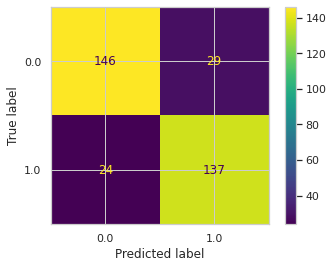

In [ ]:
estimator.fit(X_train, y_train)
y_pred = estimator.predict(X_test)
eer = compute_eer(y_test, y_pred, positive_label = 1)
print("EER: ", eer)
cm = pcm(estimator, X_test, y_test)
print(cm)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.86      0.83      0.85       175
         1.0       0.83      0.85      0.84       161

    accuracy                           0.84       336
   macro avg       0.84      0.84      0.84       336
weighted avg       0.84      0.84      0.84       336



## Random Forest (GridSearchCV)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import plot_confusion_matrix as pcm
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
X = main[:,0:-1]
y = main[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [50, 100, 250, 500]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [2, 5, 7, 10]
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

In [ ]:
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [ ]:
rf = RandomForestClassifier() 

In [ ]:
grid = RandomizedSearchCV(estimator=rf, param_distributions=random_grid, n_jobs=-1, cv=5, random_state = 42)
grid.fit(X_train, y_train)
print(grid.best_params_)

{'n_estimators': 500, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 10, 'bootstrap': True}


In [ ]:
grid.fit(X_train, y_train)
grid_pred = grid.predict(X_test) 
   
# print classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, grid_pred))
print('Accuracy : '+str(accuracy_score(y_test, grid_pred)))

              precision    recall  f1-score   support

         0.0       0.77      0.81      0.79       175
         1.0       0.78      0.73      0.76       161

    accuracy                           0.77       336
   macro avg       0.77      0.77      0.77       336
weighted avg       0.77      0.77      0.77       336

Accuracy : 0.7738095238095238


## Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import plot_confusion_matrix as pcm

In [ ]:
X = main[:,0:-1]
y = main[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [ ]:
estimator = RandomForestClassifier(n_estimators = 500, min_samples_split = 5, min_samples_leaf = 1, max_features = 'sqrt', max_depth = 10, bootstrap = True)
kfold = StratifiedKFold(n_splits=5, shuffle=True)
results = cross_val_score(estimator, X, y, cv=kfold)
print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Baseline: 80.06% (2.61%)


EER:  0.2216900808854832


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


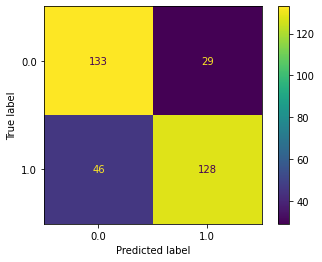

In [ ]:
estimator.fit(X_train, y_train)
y_pred = estimator.predict(X_test)
eer = compute_eer(y_test, y_pred, positive_label = 1)
print("EER: ", eer)
cm = pcm(estimator, X_test, y_test)
print(cm)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.74      0.82      0.78       162
         1.0       0.82      0.74      0.77       174

    accuracy                           0.78       336
   macro avg       0.78      0.78      0.78       336
weighted avg       0.78      0.78      0.78       336



In [ ]:
# imp = rf.feature_importances_
# print(imp[:10])

## Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
X = main[:,0:-1]
y = main[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [ ]:
estimator = LogisticRegression()
kfold = StratifiedKFold(n_splits=5, shuffle=True)
results = cross_val_score(estimator, X, y, cv=kfold)
print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Baseline: 68.10% (1.57%)


EER:  0.3230113636363636


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


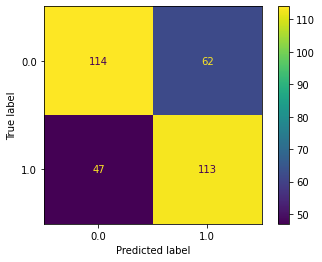

In [ ]:
estimator.fit(X_train, y_train)
y_pred = estimator.predict(X_test)
eer = compute_eer(y_test, y_pred, positive_label = 1)
print("EER: ", eer)
cm = pcm(estimator, X_test, y_test)
print(cm)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.71      0.65      0.68       176
         1.0       0.65      0.71      0.67       160

    accuracy                           0.68       336
   macro avg       0.68      0.68      0.68       336
weighted avg       0.68      0.68      0.68       336



## Conditional VAE

In [ ]:
import warnings
import numpy as np
from keras.layers import Input, Dense, Lambda
from keras.layers.merge import concatenate as concat
from keras.models import Model
from keras import backend as K
from keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
# from scipy.misc import imsave
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [ ]:
X = main[:,0:-1]
y = main[:,-1]
# (X_train, Y_train), (X_test, Y_test) = mnist.load_data()

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2)
# X_train = X_train.astype('float32') / 255.
# X_test = X_test.astype('float32') / 255.

# n_pixels = np.prod(X_train.shape[1:])
# X_train = X_train.reshape((len(X_train), n_pixels))
# X_test = X_test.reshape((len(X_test), n_pixels))


In [ ]:
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(1344, 33)
(1344,)
(336, 33)
(336,)


In [ ]:
y_train = to_categorical(Y_train)
y_test = to_categorical(Y_test)

In [ ]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(1344, 33)
(1344, 2)
(336, 33)
(336, 2)


In [ ]:
m = 250 # batch size
n_z = 2 # latent space size
encoder_dim1 = 512 # dim of encoder hidden layer
decoder_dim = 512 # dim of decoder hidden layer
decoder_out_dim = 784 # dim of decoder output layer
activ = 'relu'
optim = Adam(lr=0.001)


n_x = X_train.shape[1]
n_y = y_train.shape[1]


n_epoch = 50

In [ ]:
X = Input(shape=(n_x,))
label = Input(shape=(n_y,))

In [ ]:
inputs = concat([X, label])

In [ ]:
encoder_h = Dense(encoder_dim1, activation=activ)(inputs)
mu = Dense(n_z, activation='linear')(encoder_h)
l_sigma = Dense(n_z, activation='linear')(encoder_h)

In [ ]:
def sample_z(args):
    mu, l_sigma = args
    eps = K.random_normal(shape=(m, n_z), mean=0., stddev=1.)
    return mu + K.exp(l_sigma / 2) * eps


# Sampling latent space
z = Lambda(sample_z, output_shape = (n_z, ))([mu, l_sigma])

In [ ]:
z = Lambda(sample_z, output_shape = (n_z, ))([mu, l_sigma])

# merge latent space with label
zc = concat([z, label])

In [ ]:
decoder_hidden = Dense(decoder_dim, activation=activ)
decoder_out = Dense(decoder_out_dim, activation='sigmoid')
h_p = decoder_hidden(zc)
outputs = decoder_out(h_p)

In [ ]:
def vae_loss(y_true, y_pred):
    recon = K.sum(K.categorical_crossentropy(y_true, y_pred), axis=-1)
    kl = 0.5 * K.sum(K.exp(l_sigma) + K.square(mu) - 1. - l_sigma, axis=-1)
    return recon + kl

def KL_loss(y_true, y_pred):
	return(0.5 * K.sum(K.exp(l_sigma) + K.square(mu) - 1. - l_sigma, axis=1))

def recon_loss(y_true, y_pred):
	return K.sum(K.categorical_crossentropy(y_true, y_pred), axis=-1)

In [ ]:
cvae = Model([X, label], outputs)
encoder = Model([X, label], mu)

d_in = Input(shape=(n_z+n_y,))
d_h = decoder_hidden(d_in)
d_out = decoder_out(d_h)
decoder = Model(d_in, d_out)

In [ ]:
cvae.compile(optimizer=optim, loss='categorical_crossentropy', metrics = 'accuracy')

In [ ]:
cvae_hist = cvae.fit([X_train, y_train], X_train, verbose = 1, batch_size=m, epochs=n_epoch,
							validation_data = ([X_test, y_test], X_test),
							callbacks = [EarlyStopping(patience = 5)])

Epoch 1/50


ValueError: ignored

In [ ]:
normal_hidden_rep = encoder.predict(X[y==0])
fraud_hidden_rep = encoder.predict(X[y==1])
  
# Combining the encoded points into a single table 
encoded_X = np.append(normal_hidden_rep, fraud_hidden_rep, axis = 0)
y_normal = np.zeros(normal_hidden_rep.shape[0])
y_fraud = np.ones(fraud_hidden_rep.shape[0])
encoded_y = np.append(y_normal, y_fraud)

TypeError: ignored

In [ ]:
X_train_encoded, X_test_encoded, y_train_encoded, y_test_encoded = train_test_split(encoded_X, encoded_y, test_size = 0.2)

## Conditional VAE-2

In [ ]:
import numpy as np
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import matplotlib.pyplot as plt

Instructions for updating:
non-resource variables are not supported in the long term


In [ ]:
lr = 1e-3
epochs = 20000
img_dim = 784 #28x28 images
nn_dim = 512 #encoder/decoder dense layer
lv_dim = 2 #lower dimensional representation
lab_dim = 10 #10 labels for mnist

In [ ]:
def Xavier(in_shape):
  return tf.random.normal(shape = in_shape, stddev = 1./tf.sqrt(in_shape[0]/2.))

In [ ]:
Weight = {'W_inp_enc' : tf.Variable(Xavier([img_dim + lab_dim, nn_dim])),
          'W_enc_mean' : tf.Variable(Xavier([nn_dim, lv_dim])),
          'W_enc_std' : tf.Variable(Xavier([nn_dim, lv_dim])),
          'W_lv_dec' : tf.Variable(Xavier([lv_dim + lab_dim, nn_dim])),
          'W_dec_out' : tf.Variable(Xavier([nn_dim, img_dim]))    
}

Bias = {'B_enc' : tf.Variable(Xavier([nn_dim])),
        'B_mean' : tf.Variable(Xavier([lv_dim])),
        'B_std' : tf.Variable(Xavier([lv_dim])),
        'B_dec' : tf.Variable(Xavier([nn_dim])),
        'B_out' : tf.Variable(Xavier([img_dim]))
}

In [ ]:
temp_in = tf.placeholder(tf.float32, shape = [None, img_dim])

lab = tf.placeholder(tf.float32, shape = [None, lab_dim]) #label

inp = tf.concat(axis = 1, values = [temp_in, lab])
print(inp.shape)

encoder = tf.add(tf.matmul(inp, Weight['W_inp_enc']), Bias['B_enc'])
encoder = tf.nn.tanh(encoder)

mean = tf.add(tf.matmul(encoder, Weight['W_enc_mean']), Bias['B_mean'])
stddev = tf.add(tf.matmul(encoder, Weight['W_enc_std']), Bias['B_std'])

(?, 794)


In [ ]:
epsilon = tf.random_normal(tf.shape(stddev), dtype = tf.float32, mean = 0.0, stddev = 1.0)
latent_layer = tf.add(mean, tf.exp(0.5*stddev)*epsilon)

In [ ]:
decoder_in = tf.concat(axis = 1, values = [latent_layer, lab])
decoder = tf.add(tf.matmul(decoder_in, Weight['W_lv_dec']), Bias['B_dec'])
decoder = tf.nn.tanh(decoder)

In [ ]:
out = tf.add(tf.matmul(decoder, Weight['W_dec_out']), Bias['B_out'])
out = tf.nn.sigmoid(out)
out.shape

TensorShape([Dimension(None), Dimension(784)])

In [ ]:
def loss_fn(original, reconstructed):
  eps = 1e-10
  df_loss = original*tf.log(eps + reconstructed) + ((1 - original)*tf.log(eps + 1 - reconstructed))
  df_loss = -tf.reduce_sum(df_loss, 1)
  
  kl_div = 1 + stddev - tf.square(mean) - tf.exp(stddev)
  kl_div = -0.5*tf.reduce_sum(kl_div, 1)
  
  alpha = 1
  beta = 1
  
  return tf.reduce_mean(alpha*df_loss + beta*kl_div)

In [ ]:
loss = loss_fn(temp_in, out)
optimizer = tf.train.RMSPropOptimizer(lr).minimize(loss)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [ ]:
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0
# X = main[:,0:-1]
# y = main[:,-1]

# from sklearn.model_selection import train_test_split
# x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

11501568/11490434 [==============================] - 0s 0us/step


In [ ]:
y_train = y_train.reshape(-1)
y_train[:6]
y_train = np.eye(10)[y_train]
y_train[0]

array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.])

In [ ]:
init = tf.global_variables_initializer()

sess = tf.compat.v1.Session()
sess.run(init)

x_train = np.reshape(x_train, [-1, img_dim])

losses = []

for i in range(10000):
  _, loss_val = sess.run([optimizer, loss], feed_dict = {temp_in: x_train, lab: y_train})
  losses.append(loss_val)
  if i%100 == 0:
    print("Loss after {0} epochs is {1} ".format(i, loss_val))

Loss after 0 epochs is 613.4205932617188 
Loss after 100 epochs is 183.3012237548828 
Loss after 200 epochs is 164.53236389160156 
Loss after 300 epochs is 157.1249542236328 


KeyboardInterrupt: ignored

In [ ]:
noise = tf.placeholder(tf.float32, shape = [None, lv_dim])
labs = tf.placeholder(tf.float32, shape = [None, lab_dim])
dec_inp = tf.concat(axis = 1, values = [noise, labs])
decoder = tf.add(tf.matmul(dec_inp, Weight['W_lv_dec']), Bias['B_dec'])
decoder = tf.nn.tanh(decoder)
out = tf.add(tf.matmul(decoder, Weight['W_dec_out']), Bias['B_out'])
out = tf.nn.sigmoid(out)

In [ ]:
n = 20
x_limit = np.linspace(-2,2,n)
y_limit = np.linspace(-2,2,n)

test_img = np.empty((28*n,28*n))

digit_lab = np.array([[0, 0, 0, 0, 0, 0, 0, 0, 1, 0]]*32)

for i,zi in enumerate(x_limit):
  for j,pi in enumerate(y_limit):
    #gen_layer = np.array([[zi,pi]] * 32)
    gen_layer = np.random.normal(0,1, size = [32, lv_dim])
    gen_img = sess.run(out, feed_dict = {noise : gen_layer, labs : digit_lab})
    test_img[(n-i-1)*28:(n-i)*28, j*28:(j+1)*28] = gen_img[0].reshape(28,28)
    
plt.figure(figsize = (8,10))
X,Y = np.meshgrid(x_limit, y_limit)
plt.imshow(test_img, origin = 'upper', cmap = 'gray')
plt.grid(False)
plt.show()

In [ ]:
epochs = np.arange(len(losses))
plt.plot(epochs, losses)

## Autoencoder for classification

In [ ]:
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import LeakyReLU

In [ ]:

# synthetic classification dataset
#from sklearn.datasets import make_classification
# define dataset
X = main[:,0:-1]
y = main[:,-1]
#X, y = make_classification(n_samples=1000, n_features=100, n_informative=10, n_redundant=90, random_state=1)
# summarize the dataset
print(X.shape, y.shape)

(1680, 33) (1680,)


In [ ]:
X = MinMaxScaler().fit_transform(X)

In [ ]:
print(y)

[1. 1. 1. ... 0. 0. 0.]


In [ ]:
# split into train test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)
# scale data
# t = MinMaxScaler()
# t.fit(X_train)
# X_train = t.transform(X_train)
# X_test = t.transform(X_test)

In [ ]:
n_inputs = X.shape[1]


In [ ]:
# define encoder
visible = Input(shape=(n_inputs,))
# encoder level 1
e = Dense(n_inputs*2)(visible)
e = BatchNormalization()(e)
e = LeakyReLU()(e)
# encoder level 2
e = Dense(n_inputs)(e)
e = BatchNormalization()(e)
e = LeakyReLU()(e)
# bottleneck
n_bottleneck = n_inputs
bottleneck = Dense(n_bottleneck)(e)

In [ ]:
# define decoder, level 1
d = Dense(n_inputs)(bottleneck)
d = BatchNormalization()(d)
d = LeakyReLU()(d)
# decoder level 2
d = Dense(n_inputs*2)(d)
d = BatchNormalization()(d)
d = LeakyReLU()(d)
# output layer
output = Dense(n_inputs, activation='linear')(d)
# define autoencoder model
model = Model(inputs=visible, outputs=output)

In [ ]:
# compile autoencoder model
model.compile(optimizer='adam', loss='binary_crossentropy')

In [ ]:
# fit the autoencoder model to reconstruct input
history = model.fit(X_train, y_train, epochs=50, batch_size=16, verbose=2, validation_data=(X_test, y_test))

Epoch 1/50
71/71 - 2s - loss: 0.4471 - val_loss: 1.1561 - 2s/epoch - 28ms/step
Epoch 2/50
71/71 - 0s - loss: 0.3567 - val_loss: 1.4366 - 235ms/epoch - 3ms/step
Epoch 3/50
71/71 - 0s - loss: 0.3812 - val_loss: 1.5348 - 260ms/epoch - 4ms/step
Epoch 4/50
71/71 - 0s - loss: 0.4680 - val_loss: 4.5020 - 298ms/epoch - 4ms/step
Epoch 5/50
71/71 - 0s - loss: 0.6118 - val_loss: 0.7840 - 278ms/epoch - 4ms/step
Epoch 6/50
71/71 - 0s - loss: 0.4280 - val_loss: 0.7136 - 265ms/epoch - 4ms/step
Epoch 7/50
71/71 - 0s - loss: 0.3868 - val_loss: 0.7265 - 245ms/epoch - 3ms/step
Epoch 8/50
71/71 - 0s - loss: 0.4806 - val_loss: 1.0419 - 267ms/epoch - 4ms/step
Epoch 9/50
71/71 - 0s - loss: 0.4825 - val_loss: 1.2512 - 261ms/epoch - 4ms/step
Epoch 10/50
71/71 - 0s - loss: 0.5499 - val_loss: 1.9828 - 278ms/epoch - 4ms/step
Epoch 11/50
71/71 - 0s - loss: 0.6124 - val_loss: 0.8346 - 230ms/epoch - 3ms/step
Epoch 12/50
71/71 - 0s - loss: 0.4994 - val_loss: 0.5887 - 271ms/epoch - 4ms/step
Epoch 13/50
71/71 - 0s - lo

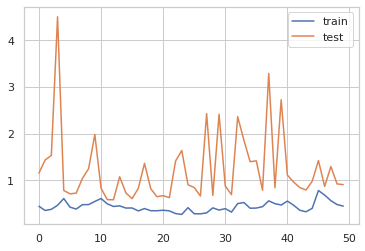

In [ ]:
# plot loss
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [ ]:
# define an encoder model (without the decoder)
encoder = Model(inputs=visible, outputs=bottleneck)
# plot_model(encoder, 'encoder_no_compress.png', show_shapes=True)
# # save the encoder to file
# encoder.save('encoder.h5')
y_pred = encoder.predict(X_test)
from sklearn.metrics import accuracy_score
print(y_test)
print(y_pred)
#print('Accuracy : '+str(accuracy_score(y_test, y_pred)))

[0. 0. 1. 1. 1. 1. 0. 1. 0. 1. 0. 1. 0. 1. 1. 1. 0. 1. 1. 1. 0. 1. 0. 1.
 1. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 1. 1. 0. 1. 0. 1. 0. 1. 0. 1. 1. 1. 1.
 0. 0. 1. 0. 1. 1. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1.
 0. 0. 1. 1. 0. 1. 1. 0. 1. 0. 1. 1. 0. 0. 1. 0. 1. 1. 1. 1. 1. 1. 0. 1.
 1. 1. 0. 1. 0. 1. 0. 1. 1. 0. 0. 1. 1. 0. 0. 1. 1. 1. 0. 1. 1. 0. 0. 0.
 0. 1. 1. 1. 1. 0. 1. 0. 1. 1. 1. 0. 0. 1. 0. 1. 0. 0. 1. 0. 1. 0. 0. 1.
 1. 1. 0. 1. 1. 0. 0. 1. 0. 0. 0. 1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 0. 0. 1.
 0. 1. 0. 0. 1. 1. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 1. 0.
 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 1. 0. 0. 1. 1. 1. 0.
 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1. 0. 0. 0. 0.
 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 1. 0. 1. 1. 0. 0.
 1. 1. 0. 1. 1. 1. 0. 0. 1. 1. 0. 1. 1. 1. 0. 1. 1. 1. 0. 0. 0. 1. 1. 1.
 0. 1. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 1. 1. 0. 1. 1. 0. 1. 0. 0. 0. 0.
 1. 1. 1. 1. 0. 1. 1. 1. 0. 0. 0. 1. 0. 0. 1. 1. 0.

## Sklearn Naive GB

In [ ]:
import numpy as np
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score

In [ ]:
X = main[:,0:-1]
y = main[:,-1]

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [ ]:
clf = GaussianNB()
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print('Accuracy : '+str(accuracy_score(y_test, y_pred)))

Accuracy : 0.6607142857142857


## GMM

In [ ]:
import numpy as np
from sklearn.mixture import GaussianMixture
from sklearn.mixture import BayesianGaussianMixture
from sklearn.metrics import accuracy_score

In [ ]:
X = main[:,0:-1]
y = main[:,-1]

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [ ]:
clf = GaussianMixture()
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print('Accuracy of Gaussian Mixture: '+str(accuracy_score(y_test, y_pred)))

Accuracy of Gaussian Mixture: 0.5099206349206349


In [ ]:
clf = BayesianGaussianMixture()
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print('Accuracy of Bayesian Gaussian Mixture: '+str(accuracy_score(y_test, y_pred)))

Accuracy of Bayesian Gaussian Mixture: 0.5099206349206349


## Encoder

https://www.geeksforgeeks.org/ml-classifying-data-using-an-auto-encoder/?ref=lbp

In [ ]:
# Loading libraries

import pandas as pd 
import numpy as np
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler 
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
from keras.layers import Input, Dense
from keras.models import Model, Sequential
from keras import regularizers

In [ ]:
# # Loading data


# # Changing the working location to the location of the data
# cd C:\Users\Dev\Desktop\Kaggle\Credit Card Fraud
  
# # Loading the dataset
# df = pd.read_csv('creditcard.csv')
  
# # Making the Time values appropriate for future work
# df['Time'] = df['Time'].apply(lambda x : (x / 3600) % 24)
  
# # Separating the normal and fraudulent transactions
# fraud = df[df['Class']== 1]
# normal = df[df['Class']== 0].sample(2500)
  
# # Reducing the dataset because of machinery constraints
# df = normal.append(fraud).reset_index(drop = True)
  
# # Separating the dependent and independent variables
# y = df['Class']
# X = df.drop('Class', axis = 1)

X = main[:,0:-1]
y = main[:,-1]

In [ ]:
# Writing function for plotting

def tsne_plot(x, y):
      
    # Setting the plotting background
    sns.set(style ="whitegrid")
      
    tsne = TSNE(n_components = 2, random_state = 0)
      
    # Reducing the dimensionality of the data
    X_transformed = tsne.fit_transform(x)
  
    plt.figure(figsize =(12, 8))
      
    # Building the scatter plot
    plt.scatter(X_transformed[np.where(y == 0), 0], 
                X_transformed[np.where(y == 0), 1],
                marker ='o', color ='y', linewidth ='1',
                alpha = 0.8, label ='Normal')
    plt.scatter(X_transformed[np.where(y == 1), 0],
                X_transformed[np.where(y == 1), 1],
                marker ='o', color ='k', linewidth ='1',
                alpha = 0.8, label ='Fraud')
  
    # Specifying the location of the legend
    plt.legend(loc ='best')
      
    # Plotting the reduced data
    plt.show()

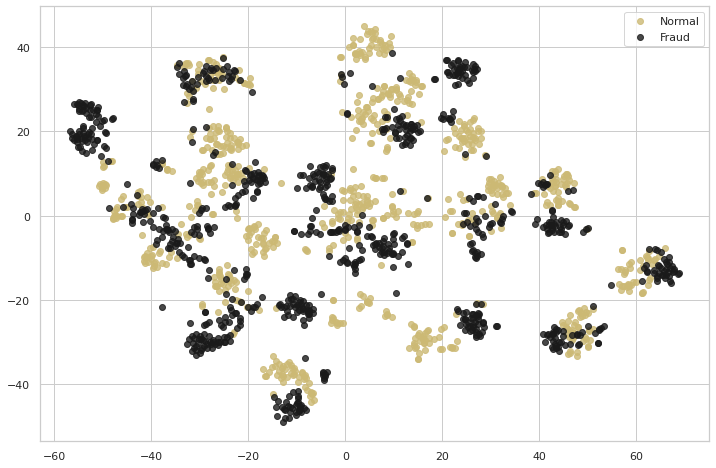

In [ ]:
# Visualizing data
tsne_plot(X, y)

In [ ]:
# Cleaning data to make it suitable for auto-encoder

X_scaled = MinMaxScaler().fit_transform(X)
X_normal_scaled = X_scaled[y == 0]
X_fraud_scaled = X_scaled[y == 1]

In [ ]:
# Building auto-encoder for neural network

# Building the Input Layer
input_layer = Input(shape =(X.shape[1], ))
  
# Building the Encoder network
encoded = Dense(100, activation ='tanh',
                activity_regularizer = regularizers.l1(10e-5))(input_layer)
encoded = Dense(50, activation ='tanh',
                activity_regularizer = regularizers.l1(10e-5))(encoded)
encoded = Dense(25, activation ='tanh',
                activity_regularizer = regularizers.l1(10e-5))(encoded)
encoded = Dense(12, activation ='tanh',
                activity_regularizer = regularizers.l1(10e-5))(encoded)
encoded = Dense(6, activation ='relu')(encoded)
  
# Building the Decoder network
decoded = Dense(12, activation ='tanh')(encoded)
decoded = Dense(25, activation ='tanh')(decoded)
decoded = Dense(50, activation ='tanh')(decoded)
decoded = Dense(100, activation ='tanh')(decoded)
  
# Building the Output Layer
output_layer = Dense(X.shape[1], activation ='relu')(decoded)

In [ ]:
# Defining and training the autoencoder

# Defining the parameters of the Auto-encoder network
autoencoder = Model(input_layer, output_layer)
autoencoder.compile(optimizer ="adadelta", loss ="binary_crossentropy")
  
# Training the Auto-encoder network
autoencoder.fit(X[y==0], X[y==0], 
                batch_size = 16, epochs = 10, 
                shuffle = True, validation_split = 0.20)

Epoch 1/10
42/42 [==============================] - 1s 8ms/step - loss: 0.0308 - val_loss: 0.0285
Epoch 2/10
42/42 [==============================] - 0s 3ms/step - loss: 0.0285 - val_loss: 0.0275
Epoch 3/10
42/42 [==============================] - 0s 3ms/step - loss: 0.0260 - val_loss: 0.0258
Epoch 4/10
42/42 [==============================] - 0s 3ms/step - loss: 0.0234 - val_loss: 0.0241
Epoch 5/10
42/42 [==============================] - 0s 3ms/step - loss: 0.0212 - val_loss: 0.0222
Epoch 6/10
42/42 [==============================] - 0s 3ms/step - loss: 0.0198 - val_loss: 0.0215
Epoch 7/10
42/42 [==============================] - 0s 3ms/step - loss: 0.0189 - val_loss: 0.0207
Epoch 8/10
42/42 [==============================] - 0s 3ms/step - loss: 0.0179 - val_loss: 0.0194
Epoch 9/10
42/42 [==============================] - 0s 3ms/step - loss: 0.0171 - val_loss: 0.0186
Epoch 10/10
42/42 [==============================] - 0s 3ms/step - loss: 0.0162 - val_loss: 0.0183


In [ ]:
# Retaining the encoder part of the Auto-encoder to encode data

hidden_representation = Sequential()
hidden_representation.add(autoencoder.layers[0])
hidden_representation.add(autoencoder.layers[1])
hidden_representation.add(autoencoder.layers[2])
hidden_representation.add(autoencoder.layers[3])
hidden_representation.add(autoencoder.layers[4])

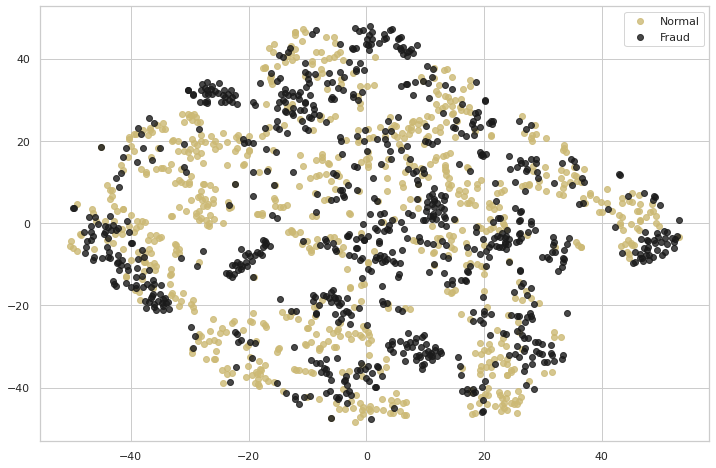

In [ ]:
# Encoding the data and visualizing the encoded data

# Separating the points encoded by the Auto-encoder as normal and fraud
normal_hidden_rep = hidden_representation.predict(X_normal_scaled)
fraud_hidden_rep = hidden_representation.predict(X_fraud_scaled)
  
# Combining the encoded points into a single table 
encoded_X = np.append(normal_hidden_rep, fraud_hidden_rep, axis = 0)
y_normal = np.zeros(normal_hidden_rep.shape[0])
y_fraud = np.ones(fraud_hidden_rep.shape[0])
encoded_y = np.append(y_normal, y_fraud)
  
# Plotting the encoded points
tsne_plot(encoded_X, encoded_y)

In [ ]:
#Splitting the original and encoded data into training and testing data

# Splitting the encoded data for linear classification
X_train_encoded, X_test_encoded, y_train_encoded, y_test_encoded = train_test_split(encoded_X, encoded_y, test_size = 0.2)
  
# Splitting the original data for non-linear classification
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [ ]:
# Building the Logistic Regression model and evaluating it’s performance

# Building the logistic regression model
lrclf = LogisticRegression()
lrclf.fit(X_train_encoded, y_train_encoded)
  
# Storing the predictions of the linear model
y_pred_lrclf = lrclf.predict(X_test_encoded)
  
# Evaluating the performance of the linear model
print('Accuracy : '+str(accuracy_score(y_test_encoded, y_pred_lrclf)))

Accuracy : 0.6488095238095238


In [ ]:
estimator = LogisticRegression()
kfold = StratifiedKFold(n_splits=5, shuffle=True)
results = cross_val_score(estimator, encoded_X, encoded_y, cv=kfold)
print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Baseline: 65.12% (3.74%)


In [ ]:
# Building the Support Vector Machine and evaluating it’s performance

# Building the SVM model
svmclf = SVC()
svmclf.fit(X_train_encoded, y_train_encoded)
  
# Storing the predictions of the non-linear model
y_pred_svmclf = svmclf.predict(X_test_encoded)
  
# Evaluating the performance of the non-linear model
print('Accuracy : '+str(accuracy_score(y_test_encoded, y_pred_svmclf)))

Accuracy : 0.6755952380952381


In [ ]:
estimator = RandomForestClassifier()
estimator.fit(X_train_encoded, y_train_encoded)
  
# Storing the predictions of the non-linear model
y_pred = estimator.predict(X_test_encoded)
  
# Evaluating the performance of the non-linear model
print('Accuracy : '+str(accuracy_score(y_test_encoded, y_pred)))

Accuracy : 0.7678571428571429


In [ ]:
estimator = SVC()
kfold = StratifiedKFold(n_splits=5, shuffle=True)
results = cross_val_score(estimator, encoded_X, encoded_y, cv=kfold)
print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Baseline: 68.33% (1.94%)


In [ ]:
estimator = RandomForestClassifier()
kfold = StratifiedKFold(n_splits=5, shuffle=True)
results = cross_val_score(estimator, encoded_X, encoded_y, cv=kfold)
print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Baseline: 75.30% (2.31%)


In [ ]:
print(encoded_X.shape, encoded_y.shape)

(1680, 12) (1680,)


In [ ]:
from pandas import read_csv
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

# baseline model
def create_baseline():
	# create model
  model = Sequential()
  model.add(Dense(12, input_dim=12, activation='relu'))
  model.add(Dense(6, activation='relu'))
  model.add(Dense(1, activation='sigmoid'))
	# Compile model
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model

estimator = KerasClassifier(build_fn=create_baseline, epochs=100, batch_size=5, verbose=0)
kfold = StratifiedKFold(n_splits=5, shuffle=True)
results = cross_val_score(estimator, encoded_X, encoded_y, cv=kfold)
print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Baseline: 70.24% (2.68%)
